# EMG Signal Processing
Author : Ramadhani Putri Alifa

## Declare function used in signal processing
1. Filtering
2. Fast fourier transform (FFT)
3. Feature Extraction
4. Windowing/Segmentation

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import seaborn as sns
from scipy.fft import fft
from scipy import signal
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing

In [2]:
def plotgambar(x, y, title):
    plt.figure(figsize=(15, 1))
    plt.plot(x, y)
    plt.xlabel('time(s)')
    plt.ylabel('amplitude (mV)')
    plt.title(title)

In [3]:
# Remove mean EMG untuk normalisasi dan kurangin noise 0Hz
def correct_mean(emg):
    return emg - np.mean(emg)

In [4]:
def highpass(emg, fch):
    b, a = signal.butter(2, fch, btype='highpass', output='ba')
    return signal.lfilter(b, a, emg)

def lowpass(emg, fcl):
    b, a = signal.butter(2, fcl, btype='lowpass', output='ba')
    return signal.lfilter(b, a, emg)

#BSF frekuensi 45-55 Hz
def BSF(emg): 
    hasilLPF = np.zeros((len(emg)))
    for i in range(1, len(emg)-1):
        if i == 1 :
            hasilLPF[i] = 0.0066*emg[i]
        elif i == 2:
            hasilLPF[i] = 0.0066*emg[i]+0.1327*emg[i-1]
        else:
            hasilLPF[i] = 0.0066*emg[i]+0.1327*emg[i-1]+0.0066*emg[i-2]-0.7832*hasilLPF[i-2]


    hasil = np.zeros((len(emg)))
    for i in range(1, len(hasilLPF)-1):
        if i == 1 :
            hasil[i] = 0.0045*hasilLPF[i]
        elif i == 2:
            hasil[i] = 0.0045*hasilLPF[i]+0.0091*hasilLPF[i-1]+1.8006*hasil[i-1]
        else:
            hasil[i] = 0.0045*hasilLPF[i]+0.0091*hasilLPF[i-1]+0.0045*hasilLPF[i-2]+1.8006*hasil[i-1]-0.8187*hasil[i-2]
    return hasilLPF

# EMG HPF //HPF 2nd order fc 20Hz
def HPF(emg):
    hasilHPF = np.zeros((len(emg)))
    for i in range(1, len(emg)-1):
        if i == 1 :
            hasilHPF[i] = 0.9565*emg[i]
        elif i == 2:
            hasilHPF[i] = 0.9565*emg[i]-1.9131*emg[i-1]+1.9112*hasilHPF[i-1]
        else:
            hasilHPF[i] = 0.9565*emg[i]-1.9131*emg[i-1]+0.9565*emg[i-2]+1.9112*hasilHPF[i-1]-0.9150*hasilHPF[i-2]
    return hasilHPF

# EMG LPF //LPF 2nd order fc 500Hz
def LPF(emg):
    hasilLPF = np.zeros((len(emg)))
    for i in range(1, len(emg)-1):
        if i == 1 :
            hasilLPF[i] = 0.2929*emg[i]
        elif i == 2:
            hasilLPF[i] = 0.2929*emg[i]+0.5858*emg[i-1]
        else:
            hasilLPF[i] = 0.2929*emg[i]+0.5858*emg[i-1]+0.2929*emg[i-2]-0.1716*hasilLPF[i-2]
    return hasilLPF

In [5]:
def fftlib(emg, fs):
    # Compute the FFT of the emg 
    fft = np.fft.fft(emg)
    # Compute the frequency axis
    freq = np.fft.fftfreq(len(emg), 1/fs)
    frequencies = freq[:len(emg)//2]
    # Compute the power spectrum
    power_spectrum = np.abs(fft)
    spectrum = power_spectrum[:len(emg)//2]

    plt.figure(figsize=((10,5)))
    plt.stem(frequencies, spectrum)
    # plt.plot(freq[:len(emg)], power_spectrum[:len(emg)])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title("Frequency Domain")
    plt.xlim([0, np.max(fs)/2])
    plt.show()

    return frequencies, spectrum

def fftmanual (emg):
    emg = np.asarray(emg, dtype=complex)
    N = emg.shape[0]
    if N <= 1:
        return emg
    even = fftmanual(emg[::2])
    odd = fftmanual(emg[1::2])
    factor = np.exp(-2j * np.pi * np.arange(N) / N)
    return np.concatenate([even + factor[:N//2] * odd, even + factor[N//2:] * odd])

def fftshift(x):
    N = len(x)
    return np.concatenate((x[:N//2], x[N//2:]))

def fftfreq(n, d=1.0):
    return np.fft.fftfreq(n, d)

def fftmagnitude(emg, sampling_frequency):
    N = len(emg)
    padded_size = int(2**(np.ceil(np.log2(N))))
    signal_padded = np.zeros(padded_size)
    signal_padded[:N] = emg
    X = fftmanual(signal_padded)
    frequencies = abs(fftfreq(padded_size) * sampling_frequency)
    magnitude_spectrum = np.abs(fftshift(X))

    plt.figure(figsize=((10,5)))
    plt.stem(frequencies, magnitude_spectrum, linefmt='orange', markerfmt='o', basefmt=' ')
    plt.setp(plt.stem(frequencies, magnitude_spectrum, linefmt='orange', markerfmt='o', basefmt=' '), 'color', 'orange')
    plt.xlabel('Frequency (Hz)')
    # plt.plot(freq[:len(emg)], power_spectrum[:len(emg)])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title("Frequency Domain")
    plt.xlim([0, np.max(sampling_frequency)/2])

    # Find the indices of the three maximum data points
    max_indices = np.argsort(magnitude_spectrum)[-3:]
    # Add labels to the three maximum data points
    for i in max_indices:
        plt.annotate(f'{magnitude_spectrum[i]:.2f}', xy=(frequencies[i], magnitude_spectrum[i]),
                    xytext=(frequencies[i] + 5, magnitude_spectrum[i]),
                    ha='left', va='center')
    plt.show()

    return frequencies, magnitude_spectrum
    

In [6]:
#Ekstraksi Fitur
def mpf(emg, fs):
    sum1 = 0
    sum2 = 0
    frequencies, magnitude_spectrum = fftmagnitude(emg, fs)
    for n in range (round(len(emg)/2)):
        sum1 += ((n*fs/len(emg))*magnitude_spectrum[n])
        sum2 += (magnitude_spectrum[n])
    return sum1 / sum2

# EMG RMS
def rms(emg):
    return np.sqrt(np.mean(emg ** 2))

# EMG variance
def var(emg):
    return np.real((1 / (len(emg)-1)) * np.sum(np.power(emg, 2)))

# EMG energy
def energy(emg):
    return np.sum(np.power(np.absolute(emg), 2))

In [7]:
def windowing(data):
    window = 8000
    shift = 2400 #int(window/2)

    start = np.arange(0, len(data) + 1)[0:(len(data) + 1) - window:shift]
    end = np.arange(0, len(data) + 1)[window:len(data) + 1:shift]
    if start[-1] != len(data) - window:
        start = np.append(start, len(data) - window)
        end = np.append(end, len(data))
        
    # print(start,end)
    num_windows = len(start)
    # print(start,end)
    assert num_windows == len(end), "Mismatch in the number of start and end indices."
    
    windowed_data = []
    
    for i in range(num_windows):
        windowed_data.append(data[start[i]:end[i]])
    
    return windowed_data

## Import Data and Apply Declared Functions

In [9]:
def summary(copy_path):    
    # Baca data signal EMG
    updated_text = copy_path.replace('\\', '\\\\')
    data1 = pd.read_csv(updated_text,names=['n', 'amp'])
    ndata = 20000
    data1 = data1.amp[0:ndata]

    time = 1/800
    t = np.arange(0, ndata)*time

    # Raw Data
    plotgambar(t, data1, 'Raw Data Signal')
    
    crmean = correct_mean(data1)
    plotgambar(t, crmean, 'Mean Corrected Signal')

    # LPF 20 Hz
    emg_lpf = lowpass(crmean, 0.5)
    plotgambar(t, emg_lpf, 'Low Pass Filtered Signal')

    # HPF 500 Hz
    emg_hpf = HPF(emg_lpf)
    plotgambar(t, emg_hpf, 'High Pass Filtered Signal')

    windowed_data = windowing(emg_hpf)
    num_windows = len(windowed_data)
    print("Number of windows:", num_windows)

    for i in range(num_windows):
        print("Window", i+1, ":", windowed_data[i])

    emg_mpf = []
    emg_rms = []
    emg_var = []
    emg_energy = []
    datatampil = []

    for i in range(num_windows):
        rms_value = rms(windowed_data[i])
        emg_rms.append(rms_value)

        var_value = var(windowed_data[i])
        emg_var.append(var_value)

        energy_value = energy(windowed_data[i])
        emg_energy.append(energy_value)
 
        mpf_value = mpf(windowed_data[i], 2000)
        emg_mpf.append(mpf_value)

        datatampil.append([emg_mpf[i], emg_rms[i], emg_var[i], emg_energy[i]])

        df = pd.DataFrame(datatampil,
                    columns=('MPF', 'RMS', 'VAR', 'ENERGY'))
        
        df = df.round(3)

    # Mean Power Frequency
    emg_mpf = mpf(emg_hpf, 2000)
    #Root Mean Square Error
    emg_rms = rms(emg_hpf)
    # Variance
    emg_var = var(emg_hpf)
    #Energy
    emg_energy = energy(emg_hpf)
   
    return df
    

Number of windows: 6
Window 1 : [ 0.         -0.11161738 -0.3584134  ...  0.01853327 -0.01289288
 -0.10054192]
Window 2 : [-0.24861302 -0.25641813 -0.25560827 ... -0.11468403 -0.00190639
  0.11676366]
Window 3 : [-0.17026968 -0.20103501 -0.21725148 ...  0.06841413  0.02342711
 -0.01918195]
Window 4 : [ 0.03534966 -0.00743462 -0.07084957 ...  0.41143589  0.42348448
  0.4837038 ]
Window 5 : [ 0.11392062  0.02276623 -0.00117614 ... -0.06190281  0.21852173
  0.48580407]
Window 6 : [ 0.01951926  0.02727138 -0.01386559 ...  0.01683557  0.01758112
  0.        ]


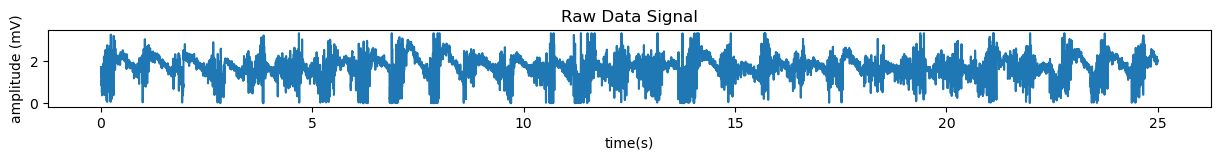

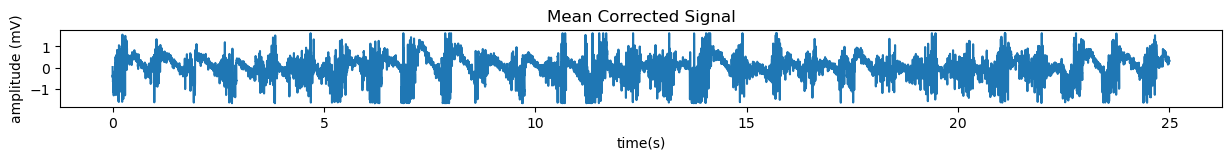

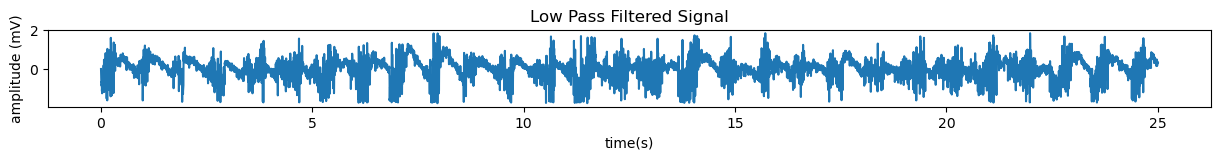

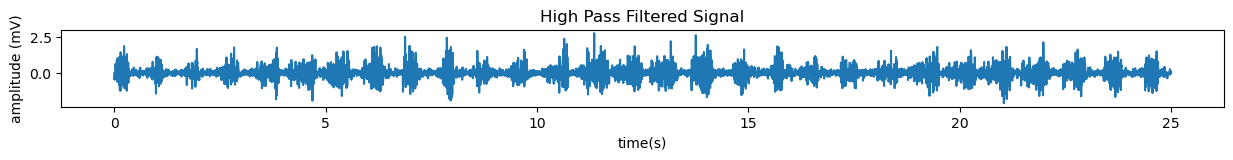

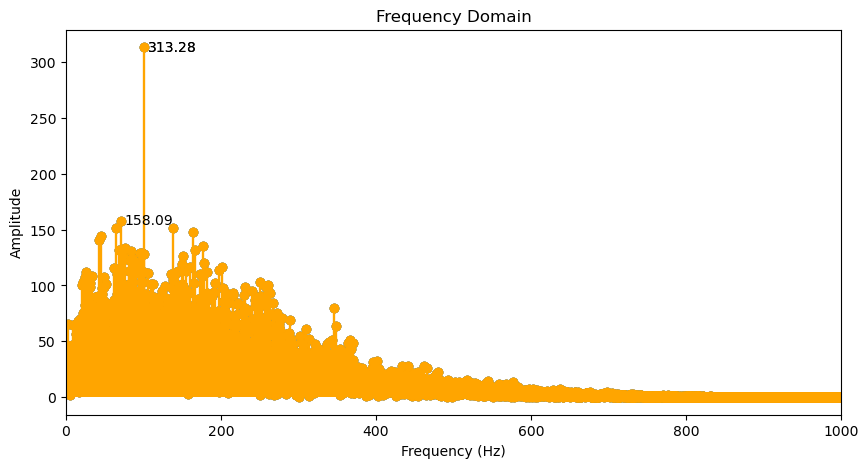

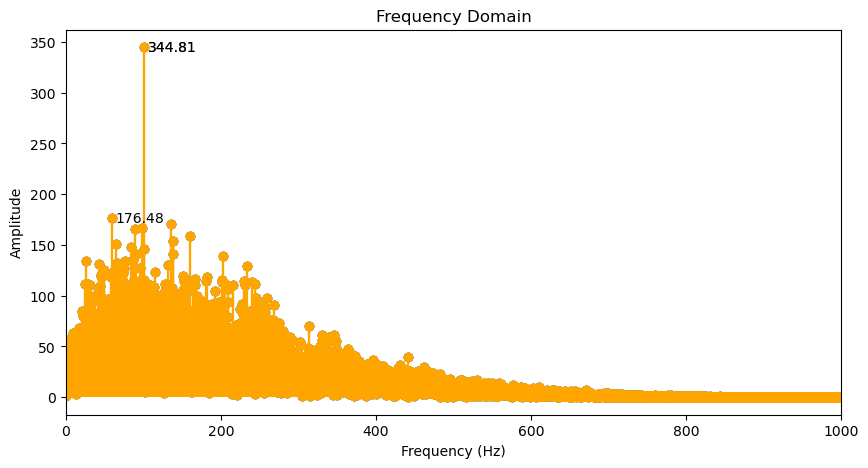

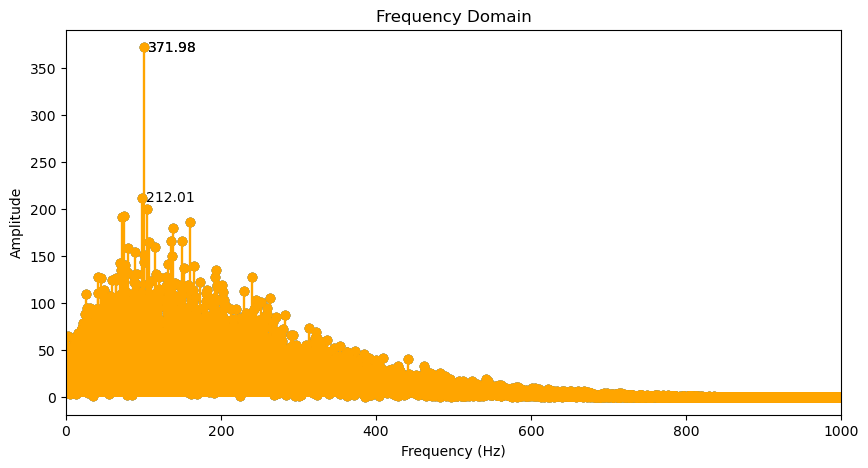

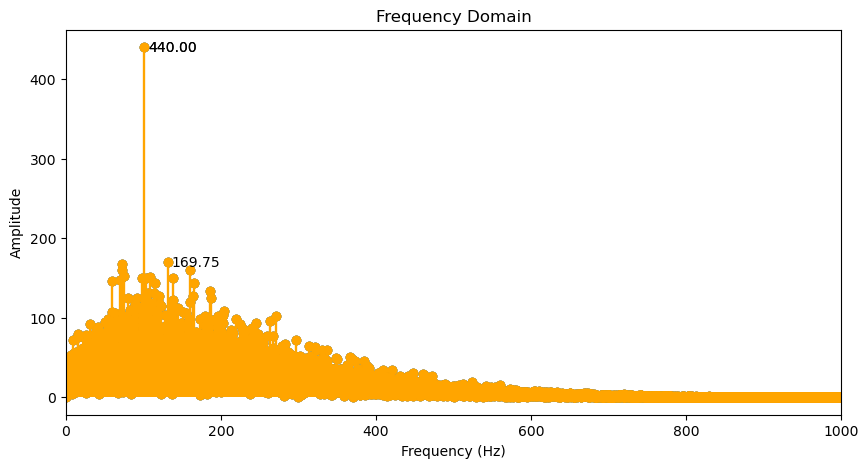

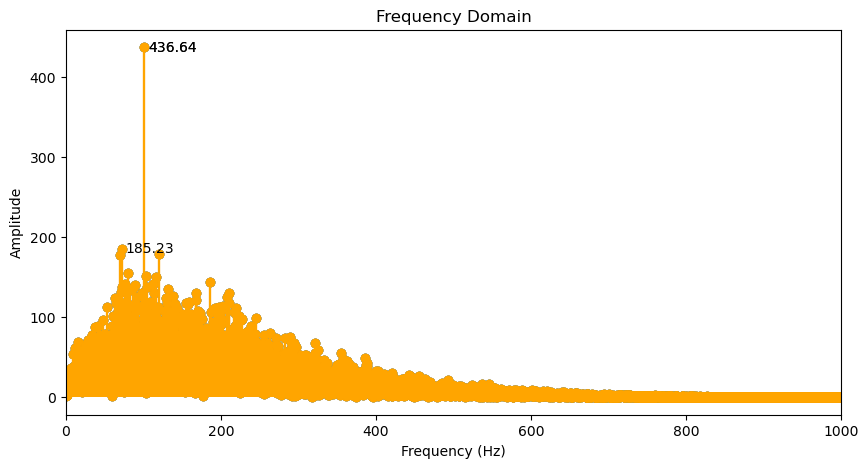

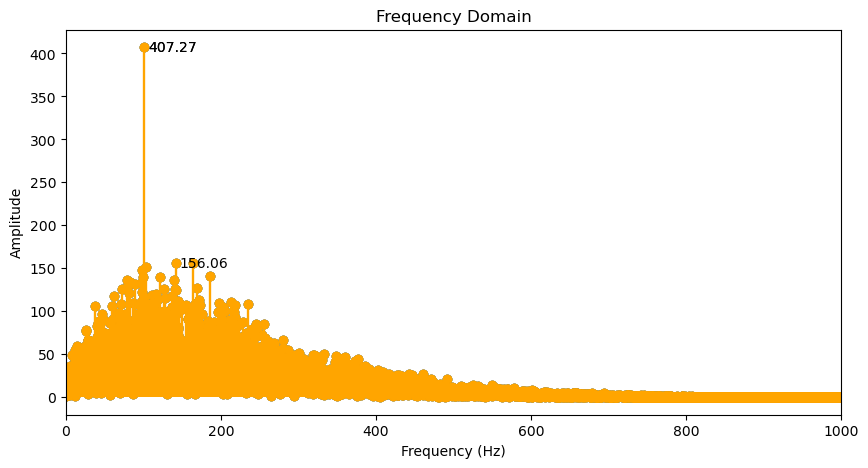

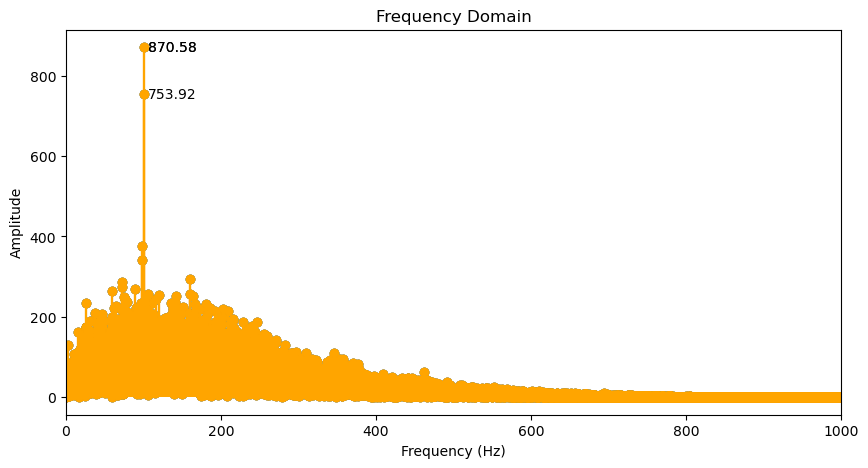

,MPF,RMS,VAR,ENERGY
0,207.369,0.362,0.131,1049.008
1,210.537,0.390,0.152,1216.361
2,211.345,0.410,0.168,1343.906
3,213.997,0.364,0.133,1060.203
4,212.847,0.375,0.141,1124.835
5,211.012,0.353,0.125,998.423


In [11]:
summary(r"E:\Semester 8\RAW DATA\17 Juni 2023\Warm up_Affan_1.txt")